# Reinforcement Learning Assignment
# Antoine BOHIN

## Setup & Utils

In [ ]:
!python3 -m pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

In [27]:
import os
import sys
import time
import gymnasium as gym
import numpy as np
import text_flappy_bird_gym
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm  # Progress bar for multiple runs
import pickle

In [28]:
def create_env(env_name='TextFlappyBird-v0', height=15, width=20, pipe_gap=4):
    if env_name=='TextFlappyBird-v0':
        return gym.make(env_name, height=height, width=width, pipe_gap=pipe_gap)

### Plotting utils

In [29]:
def sensitivity_analysis(param_name, param_values, agent_fn, fixed_params, episodes=1500, last_episodes=500):
    """
    Test agent sensitivity to a hyperparameter by varying its value and measuring performance.
    """
    avg_rewards = []

    for value in tqdm(param_values, desc=f"Testing {param_name}"):
        env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
        
        params = fixed_params.copy()
        params[param_name] = value
        
        _, rewards, _, _ = agent_fn(env, episodes, **params)  
        avg_rewards.append(np.mean(rewards[:-last_episodes]))  
        env.close()
    
    plt.figure(figsize=(8, 5))
    plt.plot(param_values, avg_rewards)
    plt.xlabel(param_name)
    plt.ylabel(f"Average Reward per Episode (last {last_episodes} episodes)")
    plt.title(f"Sensitivity to {param_name}")
    plt.grid()
    plt.show()

def plot_flappy_bird_values(Q, state_visits, agent_type):
    """
    Plots two 3D state-value functions for Flappy Bird (one for each action)
    and a heatmap below them to visualize when flapping is preferred over staying still.
    
    Parameters:
    - Q: The learned Q-table (dict mapping (x, y) -> [Q_no_flap, Q_flap]).
    - agent_type: "MC" or "Sarsa" (for labeling).
    """
    states = np.array(list(Q.keys()))
    x_positions = states[:, 0]  # Horizontal distance to pipe gap
    y_positions = states[:, 1]  # Vertical distance from pipe gap

    Q_no_flap = np.array([Q[tuple(s)][0] for s in states])  # Q-value for "no flap"
    Q_flap = np.array([Q[tuple(s)][1] for s in states])  # Q-value for "flap"
    Q_diff = Q_flap - Q_no_flap  # Difference (flap preference)

    X, Y = np.meshgrid(np.unique(x_positions), np.unique(y_positions)[::-1])
    Z_no_flap = np.zeros(X.shape)
    Z_flap = np.zeros(X.shape)
    Z_diff = np.zeros(X.shape)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            state = (X[i, j], Y[i, j])
            if state in state_visits and state_visits[state] > 0:
                Z_no_flap[i, j] = Q[state][0]  
                Z_flap[i, j] = Q[state][1]  
                Z_diff[i, j] = Q[state][1] - Q[state][0]  

    fig = plt.figure(figsize=(12, 14))

    # 3D plot for Q_no_flap
    ax1 = fig.add_subplot(221, projection="3d")
    ax1.plot_surface(X, Y, Z_no_flap, cmap=plt.cm.coolwarm)
    ax1.set_xlabel("Horizontal Distance to Pipe Gap")
    ax1.set_ylabel("Vertical Distance to Pipe Gap")
    ax1.set_zlabel("Q-value (No Flap)")
    ax1.set_title(f"State-Value Function - No Flap ({agent_type} Agent)")

    # 3D plot for Q_flap
    ax2 = fig.add_subplot(222, projection="3d")
    ax2.plot_surface(X, Y, Z_flap, cmap=plt.cm.coolwarm)
    ax2.set_xlabel("Horizontal Distance to Pipe Gap")
    ax2.set_ylabel("Vertical Distance to Pipe Gap")
    ax2.set_zlabel("Q-value (Flap)")
    ax2.set_title(f"State-Value Function - Flap ({agent_type} Agent)")

    # Heatmap for Q_flap - Q_no_flap
    ax3 = fig.add_subplot(212)
    c = ax3.pcolormesh(X, Y, Z_diff, cmap="coolwarm", shading="auto")
    fig.colorbar(c, ax=ax3, label="<-- No Flap      VS.      Flap -->")
    ax3.set_xlabel("Horizontal Distance to Pipe Gap")
    ax3.set_ylabel("Vertical Distance to Pipe Gap")
    ax3.set_title(f"Flap Preference Heatmap ({agent_type} Agent)")
    ax3.invert_yaxis()
    ax3.invert_xaxis()

    plt.tight_layout()
    plt.show()

## Monte Carlo Control: Epsilon-greedy Agent Implementation

### Implementation

The Monte Carlo Control algorithm estimates the action-value function Q(s, a) using full-episode returns and improves the policy using $\epsilon$-greedy exploration. It updates Q-values only after an episode ends

In [30]:
def monte_carlo_agent(env, episodes=1000, gamma=1.0, epsilon=0.1, checkpoints=[0.01, 0.05, 0.1, 0.3]):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns = defaultdict(list)
    rewards_per_episode = []
    state_visits = defaultdict(int)
    state_visits_snapshots = {}  

    checkpoint_steps = [int(episodes * c) for c in checkpoints]
    
    for episode in range(episodes):
        state = env.reset()[0]
        episode_data = []
        total_reward = 0

        done = False
        while not done:
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])
            
            next_state, reward, done, _, _ = env.step(action)
            episode_data.append((state, action, reward))
            state_visits[state] += 1
            state = next_state
            total_reward += reward
        
        rewards_per_episode.append(total_reward)
        
        G = 0 
        visited_states = set()
        for state, action, reward in reversed(episode_data):
            G = gamma * G + reward
            if (state, action) not in visited_states:
                visited_states.add((state, action))
                returns[(state, action)].append(G)
                Q[state][action] = np.mean(returns[(state, action)])

        if episode in checkpoint_steps:
            state_visits_snapshots[episode] = state_visits.copy()  
    
    return Q, rewards_per_episode, state_visits, state_visits_snapshots

### Parameter-Sensitivity Analysis

The $\epsilon$ parameter, which controls the balance between exploration and exploitation, showed an optimal range between 0.05 and 0.1. This aligns with expected reinforcement learning behavior: at very low values ($\epsilon < 0.05$ ), the agent does not explore enough, leading to potential suboptimal policies. Conversely, at higher values ($\epsilon > 0.2$ ), excessive exploration disrupts learning, causing a steady performance decline. Based on these observations, we selected $\epsilon = 0.05$.

Testing epsilon: 100%|██████████| 100/100 [06:09<00:00,  3.70s/it]


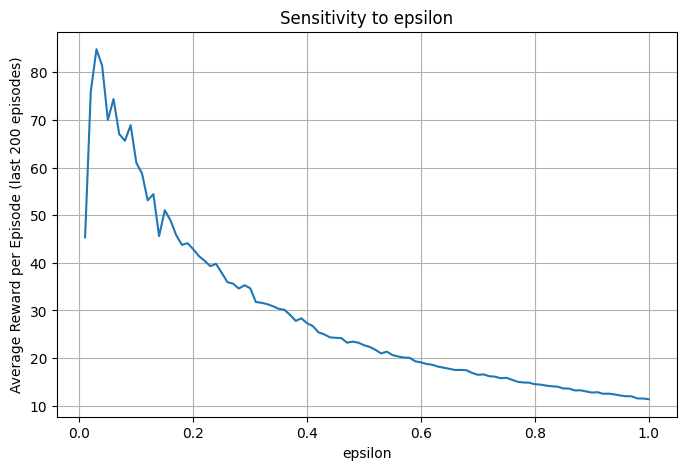

In [11]:
epsilon_values = np.linspace(0.01, 1.0, 100)
mc_fixed_params = {"gamma": 1.0, "epsilon": 0.1}
sensitivity_analysis("epsilon", epsilon_values, monte_carlo_agent, mc_fixed_params, episodes=5000)

The $\gamma$ parameter, which determines how much the agent values future rewards, showed that moderate-to-high values $0.8 - 0.95$  performed best. In Flappy Bird, survival relies on a sequence of well-timed actions, so the agent needs to consider long-term consequences. However, performance declined when $\gamma$ was too close to 1, likely due to overemphasis on long-term rewards at the cost of immediate survival actions. The final choice was $\gamma = 0.85$.

Testing gamma: 100%|██████████| 70/70 [18:54<00:00, 16.21s/it]


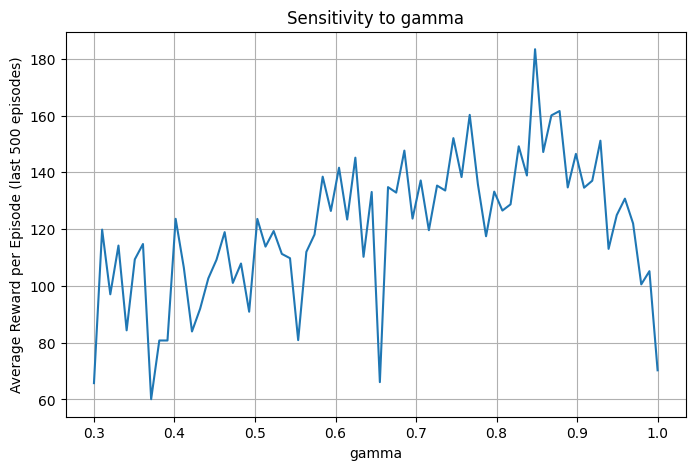

In [16]:
gamma_values = np.linspace(0.3, 1.0, 70)
mc_fixed_params = {"gamma": 1.0, "epsilon": 0.05}
sensitivity_analysis("gamma", gamma_values, monte_carlo_agent, mc_fixed_params, episodes=5000)

### Full Agent Training (20k episodes)

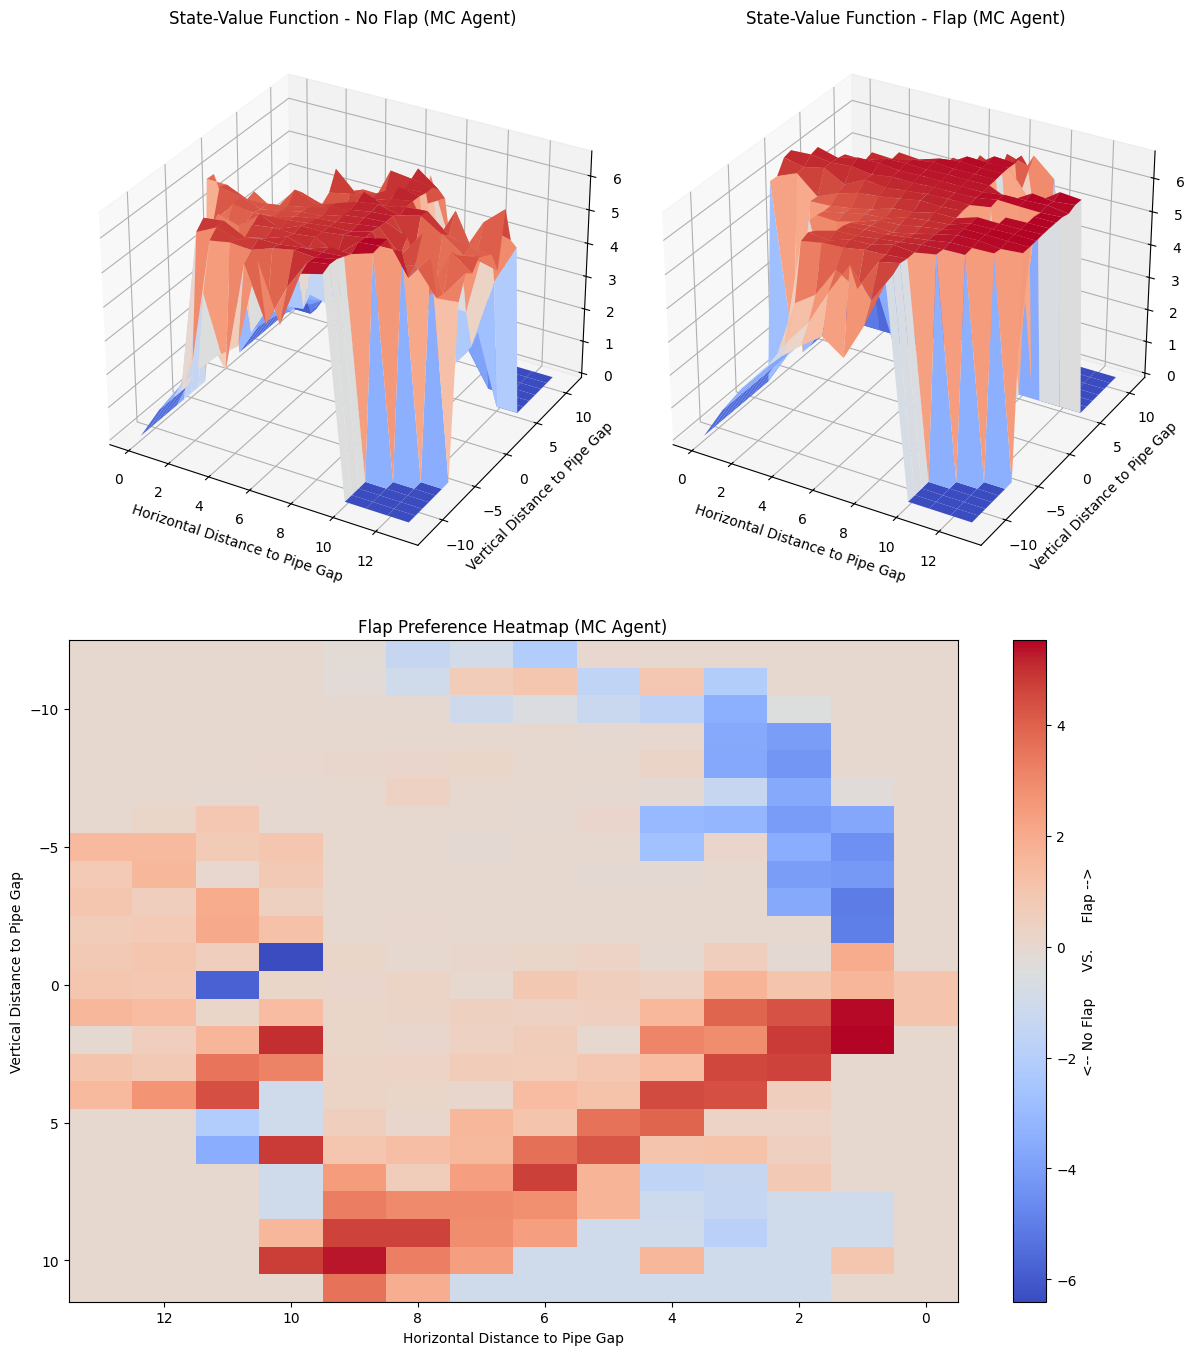

In [42]:
env = create_env()
mc_Q, mc_rewards, mc_state_visits, mc_state_visits_snapshot = monte_carlo_agent(env, gamma=0.85, epsilon=0.05, episodes=20000)
plot_flappy_bird_values(mc_Q, mc_state_visits, "MC")

with open("mc_trained_Q.pkl", "wb") as f:
    pickle.dump(dict(mc_Q), f)
with open("mc_trained_state_visits.pkl", "wb") as f:
    pickle.dump(mc_state_visits_snapshot, f)

## Sarsa($\lambda$) Agent

The Sarsa($\lambda$) algorithm is an extension of the standard Sarsa method that introduces eligibility traces, allowing past state-action pairs to receive credit for future rewards. Instead of updating only the last visited state, Sarsa($\lambda$) distributes updates across multiple past states, controlled by the trace decay parameter $\lambda$. When $\lambda=0$, the algorithm behaves like TD(0) Sarsa, updating only the most recent state, while $\lambda = 1$ makes it resemble Monte Carlo methods, incorporating full-episode returns. This balance makes Sarsa($\lambda$) particularly effective for our Flappy Bird problem requiring both short-term corrections and long-term planning.

### Implementation

In [39]:
def sarsa_lambda_agent(env, episodes=5000, gamma=1.0, lambda_=0.9, alpha=0.1, epsilon=0.1, checkpoints=[0.1, 0.5, 1.0]):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))  
    rewards_per_episode = []  
    state_visits = defaultdict(int)  
    state_visits_snapshots = {}
    checkpoint_steps = [int(episodes * c) for c in checkpoints]

    for episode in range(episodes):
        state = env.reset()[0]
        action = np.random.choice(env.action_space.n) if np.random.rand() < epsilon else np.argmax(Q[state])
        eligibility_traces = defaultdict(float) 
        total_reward = 0

        done = False
        while not done:
            next_state, reward, done, _, _ = env.step(action)
            next_action = np.random.choice(env.action_space.n) if np.random.rand() < epsilon else np.argmax(Q[next_state])
            
            delta = reward + gamma * Q[next_state][next_action] - Q[state][action]
            eligibility_traces[(state, action)] += 1  
            
            state_visits[state] += 1  

            for (s, a) in eligibility_traces:
                Q[s][a] += alpha * delta * eligibility_traces[(s, a)]
                eligibility_traces[(s, a)] *= gamma * lambda_  

            state, action = next_state, next_action
            total_reward += reward

        rewards_per_episode.append(total_reward)

        if episode in checkpoint_steps:
            state_visits_snapshots[episode] = state_visits.copy()  
    state_visits_snapshots[episode] = state_visits.copy()
    
    return Q, rewards_per_episode, state_visits, state_visits_snapshots

### Parameter-Sensitivity analysis

Optimizing Sarsa($\lambda$) proved significantly more difficult than Monte Carlo. A major reason for this is slower convergence (see following section), making early evaluation potentially misleading. Here, we analyzed results after 12,500 episodes, which gives a good performance estimate.

The $\epsilon$ parameter followed a similar trend to Monte Carlo but with a slight shift to the right, meaning that more exploration was required to reach optimal performance. This suggests that it benefits from additional exploration early on, possibly its updates after each step require more trials.

Testing epsilon: 100%|██████████| 70/70 [05:07<00:00,  4.39s/it]


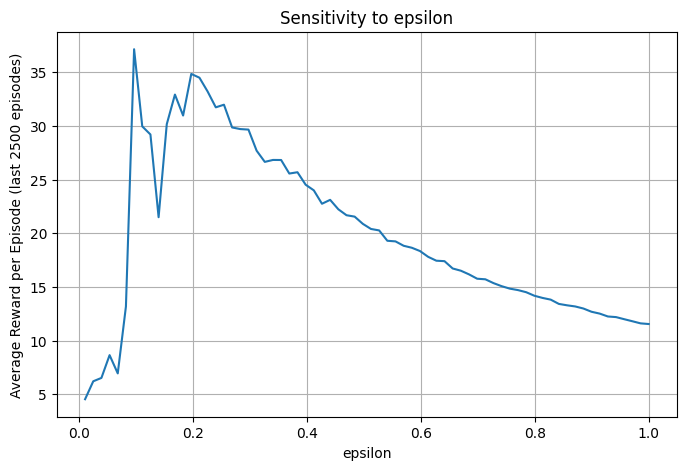

In [103]:
epsilon_values = np.linspace(0.01, 1.0, 70)
mc_fixed_params = {"gamma": 0.99, "epsilon": 0.1, "alpha": 0.1, "lambda_": 0.9}
sensitivity_analysis("epsilon", epsilon_values, sarsa_lambda_agent, mc_fixed_params, episodes=12500, last_episodes=2500)

The $\gamma$ parameter behaved similarly to Monte Carlo, where values between 0.5 and 1 performed well. However, because Sarsa($\lambda$) is an online learning algorithm, I found that higher $\gamma$ values (close to 1) yielded the best results, ensuring that the agent considered long-term consequences. Thus, I selected $\gamma = 0.99$.

Testing gamma: 100%|██████████| 70/70 [04:31<00:00,  3.88s/it]


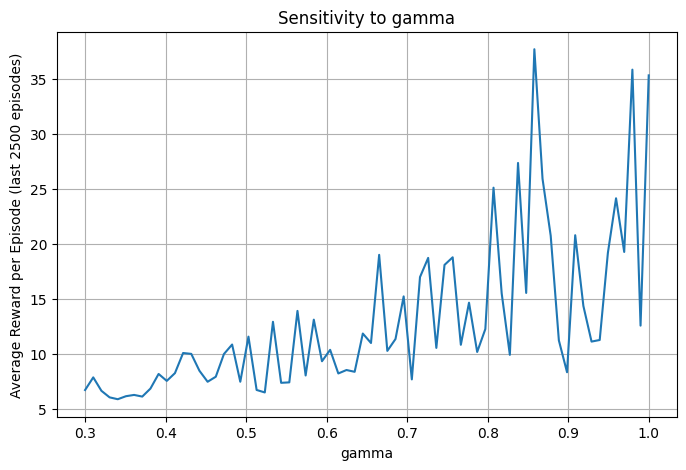

In [104]:
gamma_values = np.linspace(0.3, 1.0, 70)
mc_fixed_params = {"gamma": 0.99, "epsilon": 0.1, "alpha": 0.1, "lambda_": 0.9}
sensitivity_analysis("gamma", gamma_values, sarsa_lambda_agent, mc_fixed_params, episodes=12500, last_episodes=2500)

Sensitivity to the learning rate $\alpha$, controlling how much each update affects the Q-values. The agent was very sensitive to $\alpha$, with small adjustments greatly affecting the average score once trained. The best trade-off between stability and performance was found at $\alpha = 0.1$, allowing sufficient adaptation without excessive variance. The effect of taking even slightly lower or higher values (0.05 or 0.15) was much more visible after long training periods, emphasizing the need for careful tuning.

Testing alpha: 100%|██████████| 40/40 [06:44<00:00, 10.11s/it]


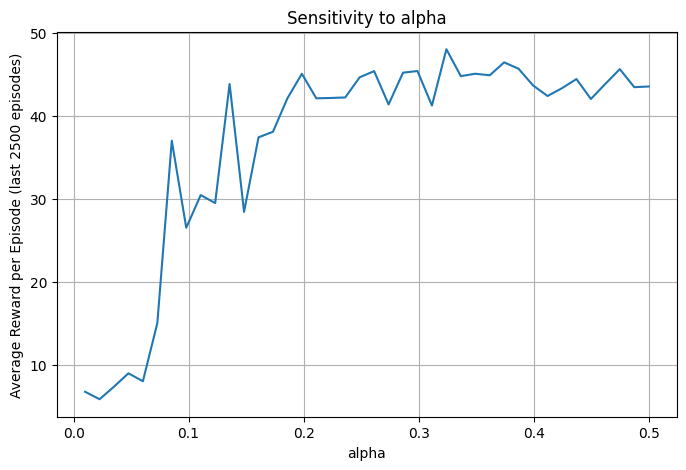

In [105]:
alpha_values = np.linspace(0.01, 0.5, 40)
sarsa_fixed_params = {"gamma": 0.99, "lambda_": 0.9, "alpha": 0.1, "epsilon": 0.1}
sensitivity_analysis("alpha", alpha_values, sarsa_lambda_agent, sarsa_fixed_params, episodes=12500, last_episodes=2500)

 The $\lambda$ parameter, which determines how far past states contribute to updates, also had a strong effect. Higher values (0.8 - 0.9) worked best, suggesting that including a broader range of past experiences helped learning.

Testing lambda_: 100%|██████████| 50/50 [04:33<00:00,  5.47s/it]


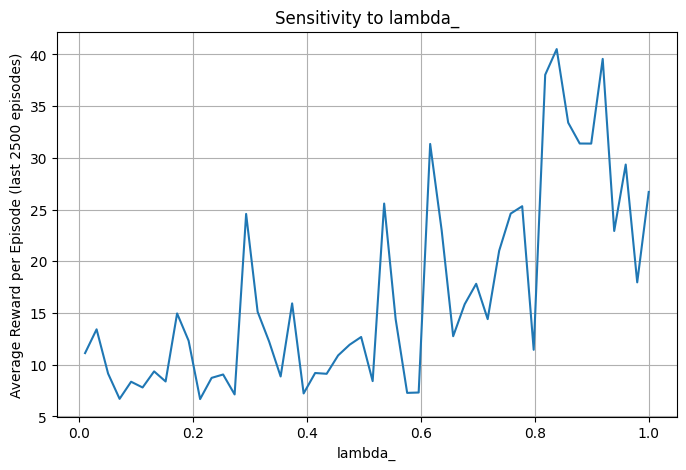

In [108]:
lambda_values = np.linspace(0.01, 1, 50)
sarsa_fixed_params = {"gamma": 0.99, "lambda_": 0.9, "alpha": 0.1, "epsilon": 0.1}
sensitivity_analysis("lambda_", lambda_values, sarsa_lambda_agent, sarsa_fixed_params, episodes=12500, last_episodes=2500)

### Full Agent Training (100k episodes)

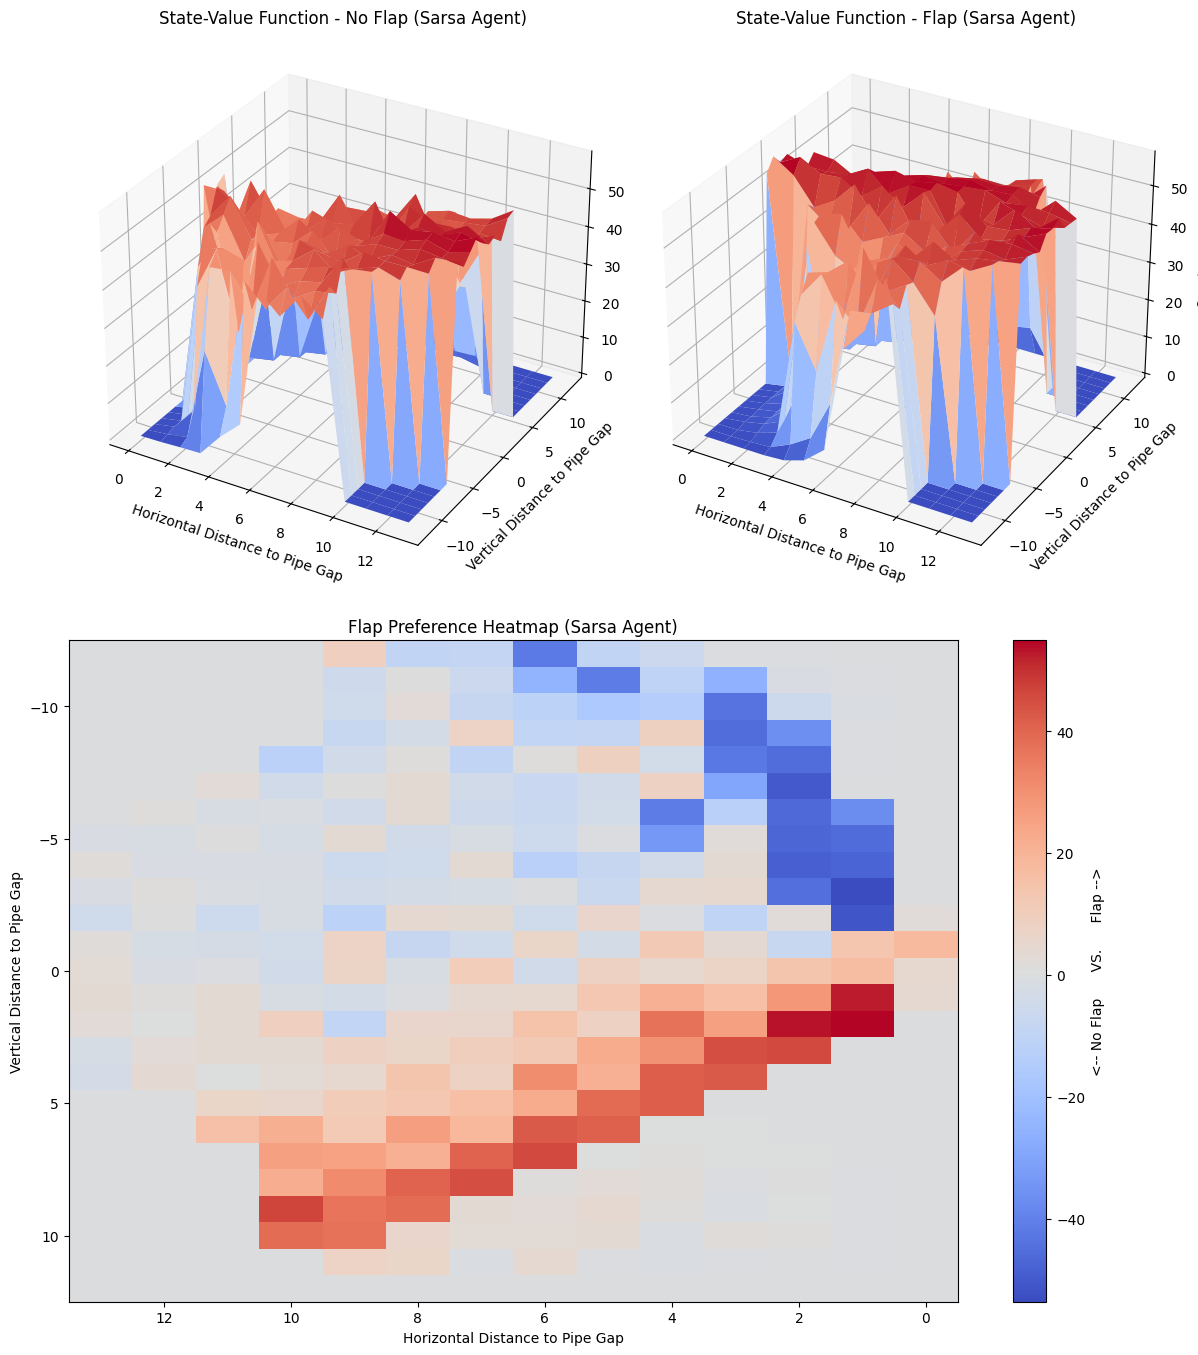

In [101]:
env = create_env()
sarsa_Q, sarsa_rewards, sarsa_state_visits, sarsa_state_visits_snapshot = sarsa_lambda_agent(env, episodes=100000, gamma=0.99, epsilon=0.1, lambda_=0.9, alpha=0.1, checkpoints=[0.01, 0.05, 0.1, 0.3, 0.7])
plot_flappy_bird_values(sarsa_Q, sarsa_state_visits, "Sarsa")
with open("sarsa_trained_Q.pkl", "wb") as f:
    pickle.dump(dict(sarsa_Q), f)
with open("sarsa_trained_state_visits.pkl", "wb") as f:
    pickle.dump(sarsa_state_visits_snapshot, f)

# Agents Comparison

## Training Process Comparison (Rewards, Convergence)

Training Sarsa(λ): 100%|██████████| 20/20 [10:41<00:00, 32.10s/it]


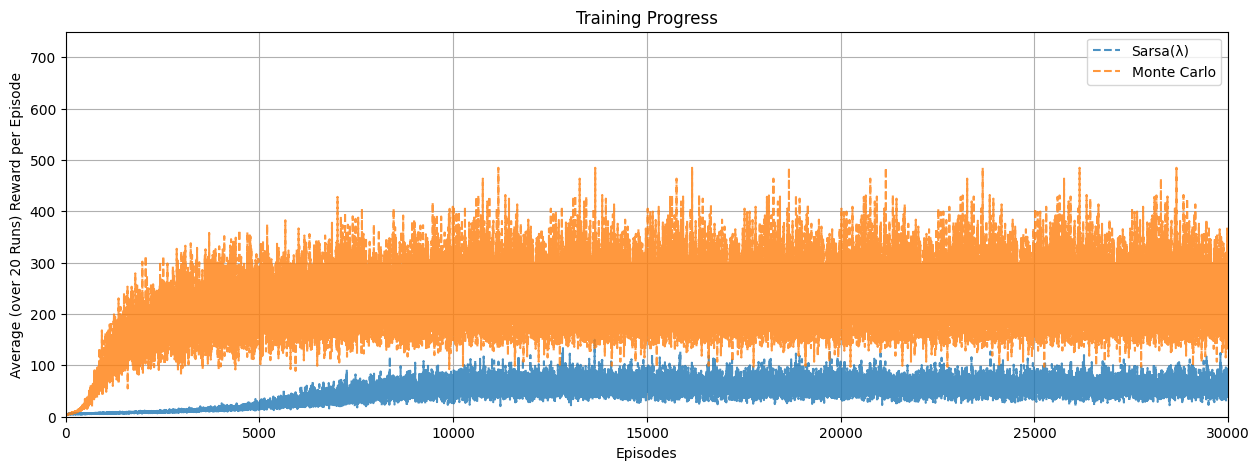

In [127]:
num_runs = 20  # Number of independent training runs
num_episodes = 30000  # Episodes per run

all_reward_sums = {"Monte Carlo": [], "Sarsa(λ)": []}

# Train both agents multiple times
for algorithm in ["Monte Carlo", "Sarsa(λ)"]:
    for run in tqdm(range(num_runs), desc=f"Training {algorithm}"):
        env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
        if algorithm == "Monte Carlo":
            _, rewards, _, _ = monte_carlo_agent(env, num_episodes, gamma=0.85, epsilon=0.05)
        elif algorithm == "Sarsa(λ)":
            _, rewards, _, _ = sarsa_lambda_agent(env, num_episodes, gamma=0.99, epsilon=0.1, lambda_=0.9, alpha=0.1)

        all_reward_sums[algorithm].append(rewards)
        env.close()

mc_rewards_avg = np.mean(all_reward_sums["Monte Carlo"], axis=0)
sarsa_rewards_avg = np.mean(all_reward_sums["Sarsa(λ)"], axis=0)

with open("mc_rewards_avg.pkl", "wb") as f:
    pickle.dump(mc_rewards_avg, f)

with open("sarsa_rewards_avg.pkl", "wb") as f:
    pickle.dump(sarsa_rewards_avg, f)

# Plot mean reward per episode across multiple runs
plt.figure(figsize=(15, 5))
plt.plot(sarsa_rewards_avg, label="Sarsa(λ)", linestyle='--', alpha=0.8)
plt.plot(mc_rewards_avg, label="Monte Carlo", linestyle='--', alpha=0.8)
plt.xlabel("Episodes")
plt.ylabel("Average (over 20 Runs) Reward per Episode")
plt.title("Training Progress")
plt.ylim([0,750])
plt.xlim([0,30000])
plt.legend()
plt.grid()

Monte Carlo (MC) control converges significantly faster, reaching high performance within 12.5k episodes, whereas Sarsa($\lambda$) required much more training to reach reasonable scores. Even after 100k episodes, Sarsa($\lambda$) still showed room for improvement, suggesting that further training could slightly enhance its final performance.

This faster convergence of MC can be attributed to its full-episode updates, where it evaluates the entire trajectory before making adjustments. This allows it to quickly identify optimal strategies, unlike Sarsa($\lambda$), which updates incrementally after each step, making it more susceptible to local fluctuations and requiring longer training to refine a stable policy.

## Performance & Generalization comparison

In [64]:
def evaluate_agent(Q, episodes=200, height=15, width=20, pipe_gap=4, max_score=200):
    """
    Evaluates a trained agent by running multiple episodes and recording the final score.
    Parameters:
    - Q: The learned Q-table (dict mapping (x, y) -> action values).
    - episodes: Number of evaluation episodes.
    """
    env = gym.make("TextFlappyBird-v0", height=height, width=width, pipe_gap=pipe_gap)
    scores = []
    for episode in tqdm(range(episodes), desc=f"Evaluating"):
        state = env.reset()[0]
        done = False
        score = 0
        while not done:
            action = np.argmax(Q[state]) if state in Q else env.action_space.sample()
            next_state, reward, done, _, info = env.step(action)

            if "score" in info:
                score = info["score"] 
            if score >= max_score:
                break
            state = next_state
        scores.append(score)
    env.close()
    return scores

Evaluating: 100%|██████████| 1000/1000 [00:01<00:00, 891.22it/s]
/var/folders/v2/ds4hxx8124q9z94wvxnvgmqh0000gn/T/ipykernel_991/1119903823.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mc_scores, mc_pipe_big_scores,mc_pipe_small_scores,  mc_height_scores],


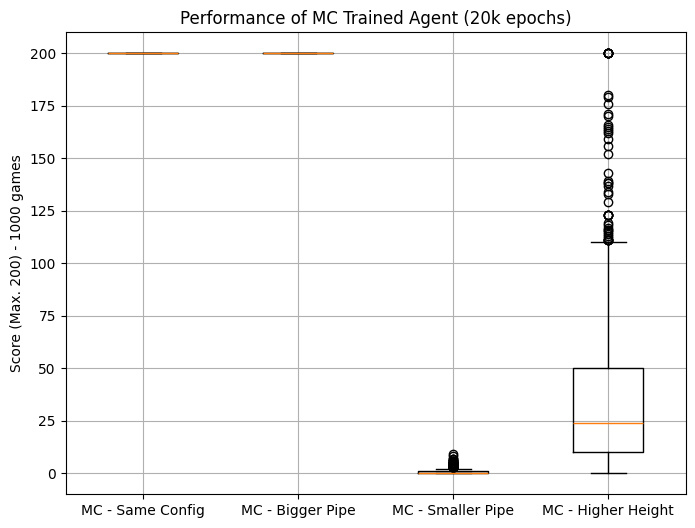

/var/folders/v2/ds4hxx8124q9z94wvxnvgmqh0000gn/T/ipykernel_991/1119903823.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ sarsa_scores, sarsa_pipe_big_scores, sarsa_pipe_small_scores, sarsa_height_scores],


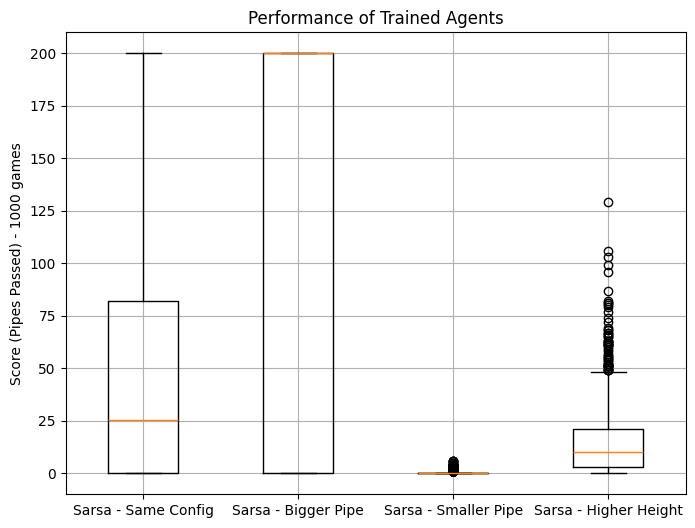

In [102]:
with open("mc_trained_Q.pkl", "rb") as f:
    mc_Q = pickle.load(f)

with open("sarsa_trained_Q.pkl", "rb") as f:
    sarsa_Q = pickle.load(f)

mc_scores = evaluate_agent(mc_Q, episodes=1000, height=15, width=20, pipe_gap=4)
sarsa_scores = evaluate_agent(sarsa_Q, episodes=1000, height=15, width=20, pipe_gap=4)

mc_pipe_small_scores = evaluate_agent(mc_Q, episodes=1000, height=15, width=20, pipe_gap=2)
sarsa_pipe_small_scores = evaluate_agent(sarsa_Q, episodes=1000, height=15, width=20, pipe_gap=2)

mc_pipe_big_scores = evaluate_agent(mc_Q, episodes=1000, height=15, width=20, pipe_gap=6)
sarsa_pipe_big_scores = evaluate_agent(sarsa_Q, episodes=1000, height=15, width=20, pipe_gap=6)

mc_height_scores = evaluate_agent(mc_Q, episodes=1000, height=20, width=20, pipe_gap=4)
sarsa_height_scores = evaluate_agent(sarsa_Q, episodes=1000, height=20, width=20, pipe_gap=4)

plt.figure(figsize=(8, 6))
plt.boxplot([mc_scores, mc_pipe_big_scores,mc_pipe_small_scores,  mc_height_scores], 
            labels=["MC - Same Config", "MC - Bigger Pipe", "MC - Smaller Pipe", "MC - Higher Height"])
plt.ylabel("Score (Max. 200) - 1000 games")
plt.title("Performance of MC Trained Agent (20k epochs)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.boxplot([ sarsa_scores, sarsa_pipe_big_scores, sarsa_pipe_small_scores, sarsa_height_scores], 
            labels=["Sarsa - Same Config", "Sarsa - Bigger Pipe", "Sarsa - Smaller Pipe", "Sarsa - Higher Height"])
plt.ylabel("Score (Pipes Passed) - 1000 games")
plt.title("Performance of Trained Agents")
plt.grid(True)
plt.show()

Monte Carlo control demonstrated remarkable consistency, achieving the maximum score in its training environment and maintaining that performance when the pipe gap increased, as the task became easier. However, its performance deteriorated sharply when tested with a smaller pipe gap, rarely exceeding a score of 10. This suggests that while the agent excels in its trained environment, its learned policy does not generalize well when the challenge requires finer control. When tested in a taller environment, the agent’s median score dropped to around 25, though some games still reached high scores beyond 100. This indicates that while MC retains some level of adaptability, it struggles to fully adjust to changes in the vertical layout of the game.

Sarsa($\lambda$), on the other hand, performed significantly worse than Monte Carlo in the original environment, with an average score around 25 and substantial variance—some games reaching the maximum score while others failing early. The high inconsistency suggests that Sarsa($\lambda$) is more sensitive to the specific game dynamics encountered during training. In a larger pipe gap setting, the agent’s performance improved, often reaching the maximum score, though its high variance remained. However, in the more difficult scenario with a smaller pipe gap, Sarsa($\lambda$) struggled even more than Monte Carlo, failing to exceed a score of 5 in most runs. When tested in a taller environment, its performance deteriorated further, reinforcing the idea that Sarsa($\lambda$)’s learned policy does not generalize well to unseen spatial configurations.

## BONUS: Game Visualization

In [67]:
def visualize_agent(env, Q, episodes=1, delay=0.2):
    """
    Run a trained agent in real-time and visualize the game.
    """
    for episode in range(episodes):
        state = env.reset()[0]
        done = False
        total_reward = 0

        print(f"Starting Episode {episode + 1}")
        while not done:
            os.system("clear")  # Clear the screen for smooth rendering
            sys.stdout.write(env.render())  # Render the game in the terminal
            sys.stdout.flush()

            # Choose the best action from Q-table (exploit)
            action = np.argmax(Q[state]) if state in Q else env.action_space.sample()
            state, reward, done, _, _ = env.step(action)
            total_reward += reward

            time.sleep(delay)  # Adjust speed for visualization

        print(f"Episode {episode + 1} finished with score: {total_reward}")

    env.close()

env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
visualize_agent(env, sarsa_Q) 

Starting Episode 1
Text Flappy Bird!
Score: 0
----------------------
[                   |]
[                    ]
[                    ]
[                    ]
[                    ]
[                   |]
[                   |]
[      @            |]
[                   |]
[                   |]
[                   |]
[                   |]
[                   |]
[                   |]
[                   |]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=13,dy=4)
Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                    ]
[                    ]
[                    ]
[                    ]
[                  | ]
[                  | ]
[      @           | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=12,dy=4)
Text Flappy Bird!
Score: 0
------------